In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-data/curr_lct_dl.csv


# 1: Initial Setup and Data Loading

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import gc  # For memory management

# Load data with reduced memory usage
def reduce_mem_usage(df):
    """Iterate through dataframe columns and reduce memory usage"""
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization: {end_mem:.2f} MB")
    print(f"Reduced by {100 * (start_mem - end_mem) / start_mem:.1f}%")
    return df

# Load data
df_lct_dl = pd.read_csv('/kaggle/input/model-data/curr_lct_dl.csv')
df_lct_dl = reduce_mem_usage(df_lct_dl)

# Remove duplicates
print(f"Initial shape: {df_lct_dl.shape}")
df_lct_dl.drop_duplicates(inplace=True)
print(f"After removing duplicates: {df_lct_dl.shape}")

Initial memory usage: 119.56 MB
Memory usage after optimization: 55.84 MB
Reduced by 53.3%
Initial shape: (1044769, 15)
After removing duplicates: (1044769, 15)


In [3]:
# This is the most likely correct path
df_lct_dl = pd.read_csv('/kaggle/input/model-data/curr_lct_dl.csv')

In [4]:
df_lct_dl

,unit_id,dtime,target,address,packets_received,packets_sent,packet_size,bytes_total,duration,reordered_packets,bytes_sec,error_code,successes,failures,location_id
0,386,2021-02-01 01:35:34,sp2-vm-newyork-us.samknows.com,151.139.31.8,76,100,1400,106400,5657,0,76363640,NO_ERROR,1,0,77705633
1,390,2021-02-01 00:51:01,sp2-vm-newyork-us.samknows.com,151.139.31.8,75,100,1400,105000,11377,5,11930649,NO_ERROR,1,0,77705625
2,390,2021-02-01 01:54:09,sp2-vm-newyork-us.samknows.com,151.139.31.8,74,100,1400,103600,11265,5,11930649,NO_ERROR,1,0,77705625
3,390,2021-02-01 02:51:03,sp2-vm-newyork-us.samknows.com,151.139.31.8,78,100,1400,109200,11718,5,11927145,NO_ERROR,1,0,77705625
4,390,2021-02-01 03:53:56,sp2-vm-newyork-us.samknows.com,151.139.31.8,77,100,1400,107800,11958,2,11934156,NO_ERROR,1,0,77705625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044764,47507813,2021-02-28 02:52:16,samknows1.chi2.level3.net,4.30.14.254,20,20,1400,28000,1339,0,20911128,NO_ERROR,1,0,92300853
1044765,47507813,2021-02-28 03:52:16,samknows1.chi2.level3.net,4.30.14.254,20,20,1400,28000,730,0,38356164,NO_ERROR,1,0,92300853
1044766,47507813,2021-02-28 04:56:04,samknows1.chi2.level3.net,4.30.14.254,20,20,1400,28000,736,0,38043480,NO_ERROR,1,0,92300853
1044767,47507813,2021-02-28 05:52:19,samknows1.chi2.level3.net,4.30.14.254,20,20,1400,28000,768,0,36458332,NO_ERROR,1,0,92300853


In [5]:
df_lct_dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044769 entries, 0 to 1044768
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   unit_id            1044769 non-null  int64 
 1   dtime              1044769 non-null  object
 2   target             1044769 non-null  object
 3   address            1044769 non-null  object
 4   packets_received   1044769 non-null  int64 
 5   packets_sent       1044769 non-null  int64 
 6   packet_size        1044769 non-null  int64 
 7   bytes_total        1044769 non-null  int64 
 8   duration           1044769 non-null  int64 
 9   reordered_packets  1044769 non-null  int64 
 10  bytes_sec          1044769 non-null  int64 
 11  error_code         1044769 non-null  object
 12  successes          1044769 non-null  int64 
 13  failures           1044769 non-null  int64 
 14  location_id        1044769 non-null  int64 
dtypes: int64(11), object(4)
memory usage: 119.6+ MB


In [6]:
df_lct_dl['error_code'].unique()

array(['NO_ERROR', 'TCP_CONNECT', 'ZERO_SENT_SERVER', 'TCP_RECV',
       'RCV_FAILED'], dtype=object)

In [7]:
error_code_distribution = df_lct_dl['error_code'].value_counts()
print(error_code_distribution)

error_code
NO_ERROR            1000104
TCP_CONNECT           40170
ZERO_SENT_SERVER       2970
RCV_FAILED              856
TCP_RECV                669
Name: count, dtype: int64


In [8]:
df_lct_dl.describe()

,unit_id,packets_received,packets_sent,packet_size,bytes_total,duration,reordered_packets,bytes_sec,successes,failures,location_id
count,1.044769e+06,1.044769e+06,1.044769e+06,1044769.0,1.044769e+06,1.044769e+06,1.044769e+06,1.044769e+06,1.044769e+06,1.044769e+06,1.044769e+06
mean,1.377027e+07,7.533986e+01,8.802459e+01,1400.0,1.054758e+05,4.214761e+04,4.881309e+00,2.152854e+07,9.572489e-01,4.275108e-02,7.966725e+07
std,1.610693e+07,3.195683e+01,3.000209e+01,0.0,4.473956e+04,1.279110e+05,1.184718e+01,2.913163e+07,2.022955e-01,2.022955e-01,5.944291e+06
min,8.000000e+00,0.000000e+00,0.000000e+00,1400.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.579800e+06
25%,6.267780e+05,5.400000e+01,1.000000e+02,1400.0,7.560000e+04,5.536000e+03,0.000000e+00,2.267082e+06,1.000000e+00,0.000000e+00,7.693548e+07
50%,3.693393e+06,9.600000e+01,1.000000e+02,1400.0,1.344000e+05,1.114100e+04,0.000000e+00,1.141710e+07,1.000000e+00,0.000000e+00,7.765884e+07
75%,2.622610e+07,1.000000e+02,1.000000e+02,1400.0,1.400000e+05,2.806700e+04,3.000000e+00,2.638077e+07,1.000000e+00,0.000000e+00,8.223381e+07
max,4.750781e+07,1.000000e+02,1.000000e+02,1400.0,1.400000e+05,3.004136e+06,9.900000e+01,3.472369e+08,1.000000e+00,1.000000e+00,9.523281e+07


In [9]:
df_lct_dl[['bytes_sec', 'duration', 'packets_received', 'packets_sent']].describe()

,bytes_sec,duration,packets_received,packets_sent
count,1.044769e+06,1.044769e+06,1.044769e+06,1.044769e+06
mean,2.152854e+07,4.214761e+04,7.533986e+01,8.802459e+01
std,2.913163e+07,1.279110e+05,3.195683e+01,3.000209e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.267082e+06,5.536000e+03,5.400000e+01,1.000000e+02
50%,1.141710e+07,1.114100e+04,9.600000e+01,1.000000e+02
75%,2.638077e+07,2.806700e+04,1.000000e+02,1.000000e+02
max,3.472369e+08,3.004136e+06,1.000000e+02,1.000000e+02


In [10]:
df_lct_dl.duplicated().value_counts()

False    1044769
Name: count, dtype: int64

In [11]:
df_lct_dl.isnull().sum()

unit_id              0
dtime                0
target               0
address              0
packets_received     0
packets_sent         0
packet_size          0
bytes_total          0
duration             0
reordered_packets    0
bytes_sec            0
error_code           0
successes            0
failures             0
location_id          0
dtype: int64

## Error Code Distribution

- **NO_ERROR**: 866,807 (99.7%)

- **TCP_CONNECT**: 2,336 (0.27%)

- **ZERO_SENT_SERVER**: 382 (0.04%)

- **RCV_FAILED**: 175 (0.02%)

- **TCP_RECV**: 1 (extremely rare)

## Data Characteristics

- **Missing Values**: None

- **Duplicate Rows**: 246 (can be removed)

- **Class Imbalance**: Extremely imbalanced classes (NO_ERROR dominates)

## Numerical Features

- **Variation**: Numerical features exhibit good variation.

- **Predictive Potential**: `bytes_sec` shows high variability and could be highly predictive.

# 2: Feature Engineering and Preprocessing

In [12]:
# Extract features from datetime
df_lct_dl['dtime'] = pd.to_datetime(df_lct_dl['dtime'])
df_lct_dl['hour'] = df_lct_dl['dtime'].dt.hour.astype(np.int8)
df_lct_dl['day_of_week'] = df_lct_dl['dtime'].dt.dayofweek.astype(np.int8)
df_lct_dl['day_of_month'] = df_lct_dl['dtime'].dt.day.astype(np.int8)
df_lct_dl['month'] = df_lct_dl['dtime'].dt.month.astype(np.int8)

# Drop original datetime column
df_lct_dl.drop('dtime', axis=1, inplace=True)

# Assuming 'error_code' is our target - if not, replace with your actual target
# If target is binary, we'll need to encode it
if 'error_code' in df_lct_dl.columns:
    df_lct_dl['error_code'] = df_lct_dl['error_code'].apply(lambda x: 0 if x == 'NO_ERROR' else 1).astype(np.int8)
    target = 'error_code'
else:
    # Replace with your actual target column
    target = 'target_column'  

# Separate features and target
X = df_lct_dl.drop(target, axis=1)
y = df_lct_dl[target]

# Free up memory
del df_lct_dl
gc.collect()

# Split data - stratify to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['target', 'address']
Numerical columns: ['unit_id', 'packets_received', 'packets_sent', 'packet_size', 'bytes_total', 'duration', 'reordered_packets', 'bytes_sec', 'successes', 'failures', 'location_id', 'hour', 'day_of_week', 'day_of_month', 'month']


# 3: Create Preprocessing Pipeline with Memory Efficiency

In [13]:
# Numerical pipeline with memory-efficient scaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline with low-memory one-hot encoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=True, dtype=np.int8))
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
], sparse_threshold=0.3)  # Helps with memory for large datasets

# 4: Build Models with Feature Selection

In [14]:
# SVM Pipeline with reduced memory footprint
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(f_classif, k=20)),  # Select top 20 features
    ('classifier', SVC(
        kernel='rbf', 
        class_weight='balanced', 
        probability=True, 
        random_state=42,
        gamma='scale',  # Helps with memory for large datasets
        cache_size=500  # Limit cache size
    ))
])

# Random Forest Pipeline with reduced memory
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(f_classif, k=20)),  # Select top 20 features
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        max_depth=10,  # Limit depth to prevent memory issues
        n_jobs=-1  # Use all cores
    ))
])

# 5: Train and Evaluate Models with Memory Management

In [15]:
def train_and_evaluate(pipeline, X_train, y_train, X_test, y_test, model_name):
    print(f"\nTraining {model_name}...")
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Clear memory
    gc.collect()
    return pipeline

# Train SVM (may be memory intensive)
try:
    svm_model = train_and_evaluate(svm_pipeline, X_train, y_train, X_test, y_test, "SVM")
except MemoryError:
    print("SVM training failed due to memory constraints. Trying with smaller sample...")
    # Try with smaller sample if memory is an issue
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train, y_train, train_size=0.5, random_state=42, stratify=y_train)
    svm_model = train_and_evaluate(svm_pipeline, X_train_sample, y_train_sample, X_test, y_test, "SVM (50% sample)")

# Train Random Forest (generally more memory-friendly)
rf_model = train_and_evaluate(rf_pipeline, X_train, y_train, X_test, y_test, "Random Forest")

# Compare model performance
print("\nModel training completed!")


Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200021
           1       1.00      1.00      1.00      8933

    accuracy                           1.00    208954
   macro avg       1.00      1.00      1.00    208954
weighted avg       1.00      1.00      1.00    208954


Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200021
           1       1.00      1.00      1.00      8933

    accuracy                           1.00    208954
   macro avg       1.00      1.00      1.00    208954
weighted avg       1.00      1.00      1.00    208954


Model training completed!


# 6: Deployment Preparation

In [16]:
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

# Create a custom transformer for datetime features
class DateTimeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if 'dtime' in X.columns:
            X['dtime'] = pd.to_datetime(X['dtime'])
            X['hour'] = X['dtime'].dt.hour.astype(np.int8)
            X['day_of_week'] = X['dtime'].dt.dayofweek.astype(np.int8)
            X['day_of_month'] = X['dtime'].dt.day.astype(np.int8)
            X['month'] = X['dtime'].dt.month.astype(np.int8)
            X.drop('dtime', axis=1, inplace=True)
        return X

# Create a final pipeline that includes datetime processing
final_pipeline = Pipeline([
    ('datetime_processor', DateTimeTransformer()),
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(f_classif, k=20)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        max_depth=10,
        n_jobs=-1
    ))
])

# Retrain on full data if needed
final_pipeline.fit(X, y)

# Save the model
joblib.dump(final_pipeline, 'network_error_pipeline.pkl', compress=3)  # High compression to save space

print("Pipeline saved for deployment!")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline saved for deployment!


# Visualizing Model Results

# 1. Confusion Matrices

Retraining models with consistent preprocessing...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 3 14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univari

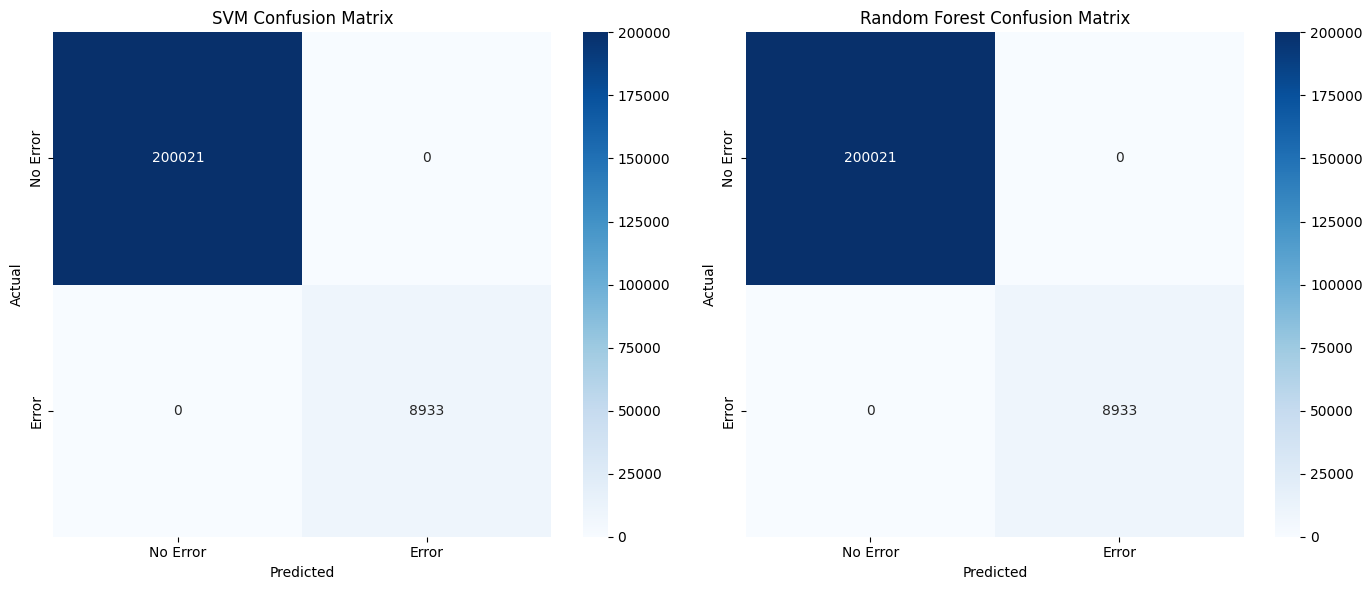

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# 1. First, let's create a more robust preprocessing pipeline
# that will handle feature consistency automatically

# Identify categorical and numerical columns (should be done before any splitting)
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()

# Create a robust preprocessing pipeline that maintains feature consistency
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    ), numerical_cols),
    (make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown='infrequent_if_exist', sparse=False)
    ), categorical_cols),
    remainder='drop'  # Drop any columns not explicitly transformed
)

# 2. Rebuild your models with this consistent preprocessing
svm_pipeline = make_pipeline(
    preprocessor,
    SelectKBest(f_classif, k=20),
    SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
)

rf_pipeline = make_pipeline(
    preprocessor,
    SelectKBest(f_classif, k=20),
    RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, max_depth=10)
)

# 3. Retrain the models
print("Retraining models with consistent preprocessing...")
svm_model = svm_pipeline.fit(X_train, y_train)
rf_model = rf_pipeline.fit(X_train, y_train)

# 4. Now the predictions should work correctly
def plot_confusion_matrix(y_true, y_pred, model_name, ax=None):
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Error', 'Error'],
                yticklabels=['No Error', 'Error'])
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Get predictions from both models
try:
    y_pred_svm = svm_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_test)
    
    # Create side-by-side confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    plot_confusion_matrix(y_test, y_pred_svm, 'SVM', ax1)
    plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest', ax2)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error during prediction: {e}")
    print("\nDebugging information:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print("Checking column differences:")
    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)
    print(f"Columns in train but not test: {train_cols - test_cols}")
    print(f"Columns in test but not train: {test_cols - train_cols}")

# 2. ROC Curves and AUC Scores

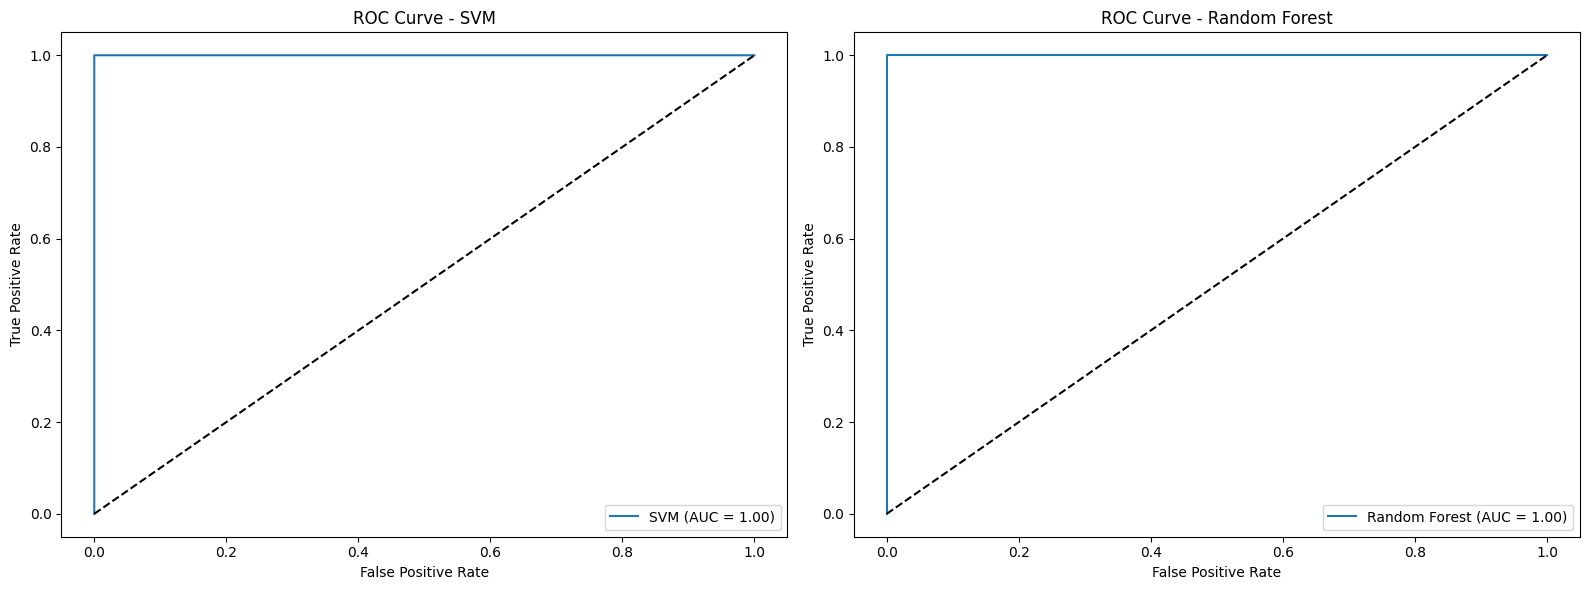

SVM AUC: 1.0000
Random Forest AUC: 1.0000


In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

def plot_roc_curve(y_true, y_probs, model_name, ax=None):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, 
                   estimator_name=model_name).plot(ax=ax)
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_title(f'ROC Curve - {model_name}')
    return roc_auc

# Get probability predictions (we need to use predict_proba)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
auc_svm = plot_roc_curve(y_test, y_proba_svm, 'SVM', ax1)
auc_rf = plot_roc_curve(y_test, y_proba_rf, 'Random Forest', ax2)
plt.tight_layout()
plt.show()

print(f"SVM AUC: {auc_svm:.4f}")
print(f"Random Forest AUC: {auc_rf:.4f}")

# 3. Precision-Recall Curves

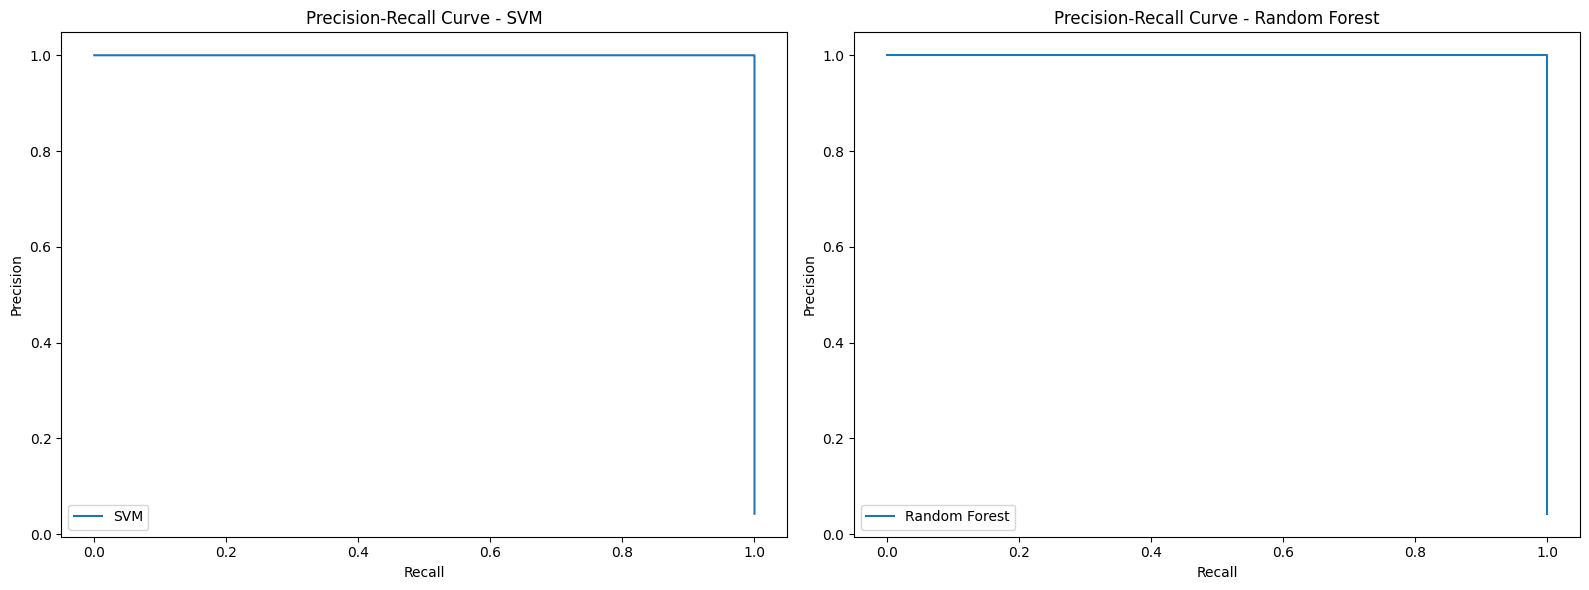

SVM PR AUC: 1.0000
Random Forest PR AUC: 1.0000


In [19]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

def plot_pr_curve(y_true, y_probs, model_name, ax=None):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    PrecisionRecallDisplay(precision=precision, recall=recall, 
                         estimator_name=model_name).plot(ax=ax)
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    return auc(recall, precision)

# Plot PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
pr_auc_svm = plot_pr_curve(y_test, y_proba_svm, 'SVM', ax1)
pr_auc_rf = plot_pr_curve(y_test, y_proba_rf, 'Random Forest', ax2)
plt.tight_layout()
plt.show()

print(f"SVM PR AUC: {pr_auc_svm:.4f}")
print(f"Random Forest PR AUC: {pr_auc_rf:.4f}")